In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

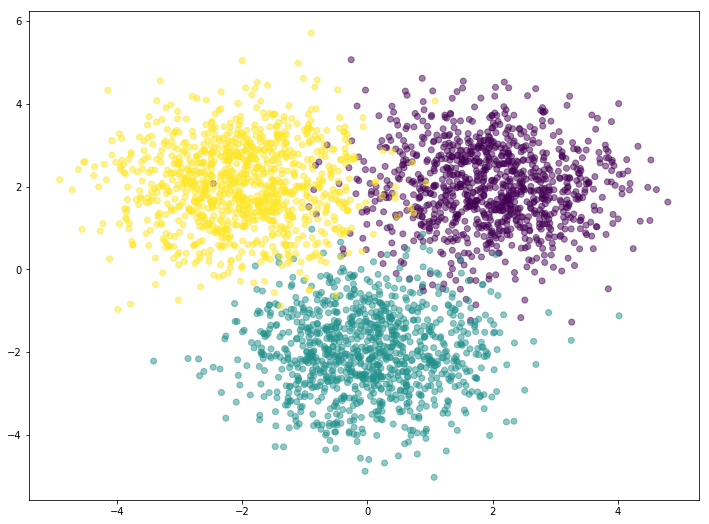

In [2]:
# Simulate data

D = 2
K = 3
N = K * 1000

X1 = np.random.randn((N/K), D) + np.array([2, 2])
X2 = np.random.randn((N/K), D) + np.array([0, -2])
X3 = np.random.randn((N/K), D) + np.array([-2, 2])
X = np.vstack((X1, X2, X3))

y = np.array([0]*(N/K) + [1]*(N/K) + [2]*(N/K))

plt.figure(figsize = (12, 9))
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)

In [3]:
# Data prep

Y = np.zeros((N, K))

for i in xrange(N):
    Y[i, y[i]] = 1

Our network architecture is as follows:

$$Z^{(1)} = \tanh(XW^{(1)} + b^{(1)})$$
$$Z^{(2)} = \sigma(Z^{(1)}W^{(2)} + b^{(2)})$$
$$Z^{(3)} = \tanh(Z^{(2)}W^{(3)} + b^{(3)})$$
$$Z^{(4)} = \sigma(Z^{(3)}W^{(4)} + b^{(4)})$$
$$\hat{P} = s\left(Z^{(4)}W^{(5)} + b^{(5)}\right)$$

In [4]:
# Functions

def sigmoid(H):
    return 1 / (1 + np.exp(-H))

def softmax(H):
    eH = np.exp(H)
    return eH / eH.sum(axis = 1, keepdims = True)

def feed_forward(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    Z1 = np.tanh(np.matmul(X, W1) + b1)
    Z2 = sigmoid(np.matmul(Z1, W2) + b2)
    Z3 = np.tanh(np.matmul(Z2, W3) + b3)
    Z4 = sigmoid(np.matmul(Z3, W4) + b4)
    P = softmax(np.matmul(Z4, W5) + b5)
    return Z1, Z2, Z3, Z4, P

def cross_entropy(Y, P):
    return -np.sum(Y * np.log(P))

def classification_rate(y, P):
    return np.mean(y == P.argmax(axis = 1))

In [11]:
# Build the Model

Q = 3
R = 4
S = 5
T = 4

W1 = np.random.randn(D, Q)
b1 = np.random.randn(Q)
W2 = np.random.randn(Q, R)
b2 = np.random.randn(R)
W3 = np.random.randn(R, S)
b3 = np.random.randn(S)
W4 = np.random.randn(S, T)
b4 = np.random.randn(T)
W5 = np.random.randn(T, K)
b5 = np.random.randn(K)

## Finding the gradients of each layer:

**Gradient with respect to logit at output layer**
$$\frac{\partial J}{\partial H^{(5)}_{k}} = \hat{p}_k - y_k$$
$$\nabla_{H^{(5)}}J = \hat{P} - Y$$

**Gradient with respect to weight matrix at output layer**
$$\frac{\partial J}{\partial W_{tk}^{(5)}} = \sum_{i=1}^{N}z^{(4)}_{it}(\hat{p}_{ik} - y_{ik})$$
$$\nabla_{W^{(5)}}J = \left(Z^{(4)} \right)^T \left(\hat{P} - Y \right)$$
$$\nabla_{W^{(5)}}J = \left(Z^{(4)} \right)^T\nabla_{H^{(5)}}J$$

**Gradient with respect to last hidden layer**
$$\frac{\partial J}{\partial Z_{it}^{(4)}} = \sum_{i=1}^{N}\sum_{k=1}^{K}\left(\hat{p}_{ik} - y_{ik}\right)W_{tk}^{(5)}$$
$$\nabla_{Z^{(4)}}J = \left(\hat{P} - Y\right)\left(W^{(5)}\right)^T$$
$$\nabla_{Z^{(4)}}J = \nabla_{H^{(5)}}J\left(W^{(5)}\right)^T$$

**Gradient with respect to the logit at the second to last layer (or last hidden layer)**
$$\frac{\partial J}{\partial H_{it}^{(4)}} = \sum_{i=1}^{N}\sum_{k=1}^{K}\left(\hat{p}_{ik} - y_{ik}\right)W_{tk}^{(5)}z_{it}^{(4)}\left(1 - (z_{it}^{(4)})\right)$$
$$\nabla_{H^{(4)}}J = \left(\hat{P} - Y\right)\left(W^{(5)}\right)^T \odot Z^{(4)}\odot \left(1 - Z^{(4)}\right)$$
$$\nabla_{H^{(4)}}J = \nabla_{Z^{(4)}}J \odot \nabla_{H^{(4)}}Z^{(4)}$$

**Gradient with respect to the weight matrix at the last hidden layer**
$$\frac{\partial J}{\partial W_{st}^{(4)}} = \sum_{i=1}^{N}\sum_{k=1}^{K}\left(\hat{p}_{ik} - y_{ik}\right)W_{tk}^{(5)}z_{it}^{(4)}\left(1 - (z_{it}^{(4)})\right)z_{is}^{(3)}$$
$$\nabla_{W^{(4)}}J = \left(Z^{(3)}\right)^T\left[\left(\hat{P} - Y\right)\left(W^{(5)}\right)^T \odot Z^{(4)} \odot \left(1 - Z^{(4)}\right)\right]$$
$$\nabla_{W^{(4)}}J = \left(Z^{(3)}\right)^T \nabla_{H^{(4)}}J$$

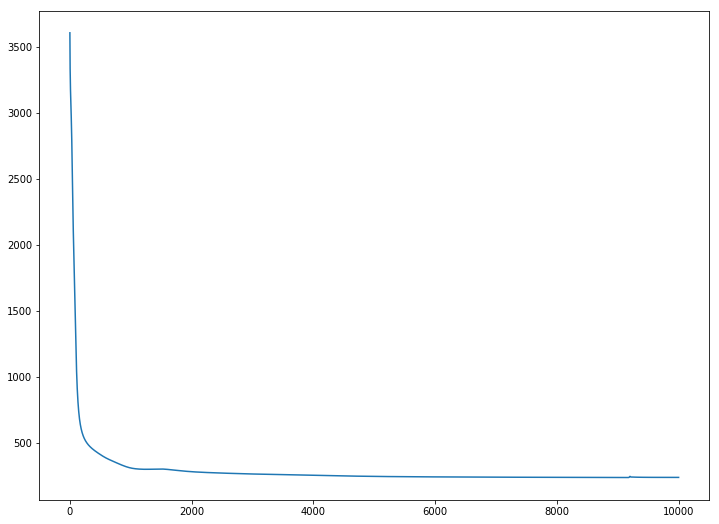

In [12]:
# Train the model

J = []
eta = 1e-4
epochs = int(1e4)

for t in xrange(epochs):
    Z1, Z2, Z3, Z4, P = feed_forward(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    J.append(cross_entropy(Y, P))
    
    dH5 = P - Y
    dW5 = np.matmul(Z4.T, dH5)
    W5 -= eta * dW5
    b5 -= eta * dW5.sum(axis = 0)
    
    dZ4 = np.matmul(dH5, W5.T)
    dH4 = dZ4 * Z4 * (1 - Z4)
    dW4 = np.matmul(Z3.T, dH4)
    W4 -= eta * dW4
    b4 -= eta * dW4.sum(axis = 0)
    
    dZ3 = np.matmul(dH4, W4.T)
    dH3 = dZ3 * (1 - Z3*Z3)
    dW3 = np.matmul(Z2.T, dH3)
    W3 -= eta * dW3
    b3 -= eta * dW3.sum(axis = 0)
    
    dZ2 = np.matmul(dH3, W3.T)
    dH2 = dZ2 * Z2 * (1 - Z2)
    dW2 = np.matmul(Z1.T, dH2)
    W2 -= eta * dW2
    b2 -= eta * dW2.sum(axis = 0)
    
    dZ1 = np.matmul(dH2, W2.T)
    dH1 = dZ1 * (1 - Z1*Z1)
    dW1 = np.matmul(X.T, dH1)
    W1 -= eta * dW1
    b1 -= eta * dW1.sum(axis = 0)
    
plt.figure(figsize = (12, 9))
plt.plot(J)

In [13]:
# Report Classification Rate

print "Classification Rate: {}".format(classification_rate(y, P))

Classification Rate: 0.971333333333


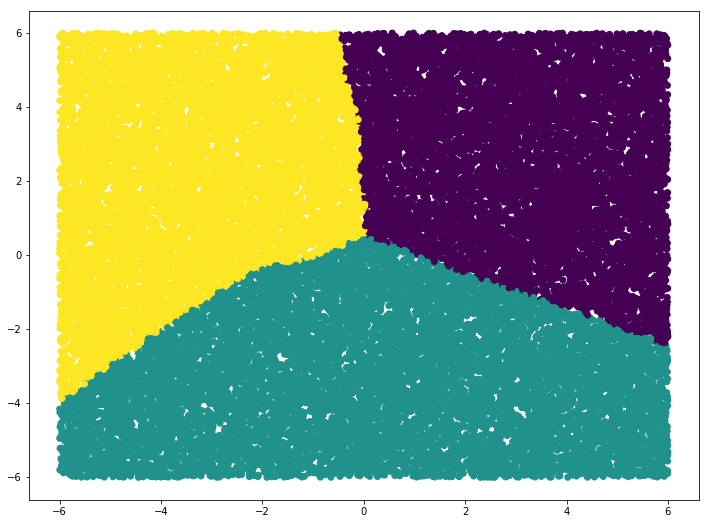

In [15]:
# Visualize Learned Decision Boundaries

X_vis = np.random.uniform(low = -6, high = 6, size = ((N * 10), D))

P_vis = feed_forward(X_vis, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)[-1]

plt.figure(figsize=(12,9))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c = P_vis.argmax(axis = 1))